# SuperLeague: an (un)expected consensus?
## All the tweets after the ill-fated announcement of the SuperLeague

### The SuperLeague debacle

On Sunday 18th of April, the European football witnessed a shocking statement: twelve of the biggest European football teams announced that they were breaking-away from their existing leagues to form a European Super League of football. 

The Super League would have weekly matches between the members, and would most likely lead to a massive redistribution of sponsoring funds from the National European leagues to the Super League. The Super League would be composed by 15 fixed members (the twelve founding clubs plus three extra clubs that were to be announced) and 5 members that would join the League on merits based on their performance in the previous season.

- Twelve clubs signed the official statement:

Manchester City, Manchester United, Liverpool, Arsenal, Chelsea, Tottenham, Real Madrid, Atletico de Madrid, Barcelona, Milan, Internazionale, and Juventus.

- Reaction of the fans:

The announcement of the Super League generated a massive lashback from fans. Fans gathered to protest against the British clubs involved, and the government and the royal family publicly stated their opposition to the proposal. 

- The collapse of the project

On Tuesday night, the six British teams dropped the project. On Wednesday, Atletico de Madrid and the Italian clubs left the project as well. At present, only Real Madrid and Barcelona still did not announce their withdrawal from the proposal.


As a fan of football, I was shocked by the Super League proposal, in particular by the fact that 15 clubs will be fixed in the league. It goes against the spirit of the game where you must earn your place amongst the big teams. 

Even if I realize that there are already many financial disparities in the European National leagues, leading to the hegemony of Paris in France, for example, the possibility that a Leicester might win the Premier League against all the odds is essential to the beauty of football.

As a data scientist, I saw in the Super League debacle a great opportunity to explore the `tweepy` package and find whether the posts in Twitter would back up my perception that fans were overwhelmingly outraged by the proposal.

### Data

In this analysis, I wanted to collect all tweets that contained the string "SuperLeague" on Monday April 19, the day immediately after the announcement of the Super League. The code snippets below show the steps to do so from the Twitter API through the `tweepy` package. For more information about it, please check the [Twitter API website](https://developer.twitter.com/en/docs/getting-started):

In [2]:
# load libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import tweepy

In [ ]:
# Paste below your API keys
API_KEY = 'YOUR-API-KEY-HERE'
API_SECRET_KEY = 'YOUR-API-SECRET-KEY-HERE'
BEARER_TOKEN = 'YOUR-BEARER-TOKEN-HERE'

Define the query: I want all tweets containing 'SuperLeague' or '#SuperLeague', and I don't want retweets:

In [ ]:
query = "SuperLeague OR #SuperLeague -filter:retweets"

The next step is to define a function to query the API:

In [ ]:
def collect_tweets(query, max_id=None, nitems=100, until=None, result_type='recent'):
    
    if until is not None:
        tweets = tweepy.Cursor(api.search,
                           q=query,
                           lang="en",
                           tweet_mode="extended",
                           result_type=result_type,
                           timezone='Europe/England',
                           until=until
                          ).items(nitems)
        
    else:
        tweets = tweepy.Cursor(api.search,
                               q=query,
                               lang="en",
                               tweet_mode="extended",
                               result_type=result_type,
                               timezone='Europe/England',
                               max_id=max_id
                              ).items(nitems)

    
    return tweets
    

Define a function to extract useful information from each tweets:

In [ ]:
def extract_tweet_info(tweets):
    tweets_infos = []
    
    for tweet in tqdm(tweets): # The tqdm function displays a progression bar to track the API calls
        tweet_info = [
            tweet.id_str,
            tweet.full_text, 
            tweet.created_at, 
            [h['text'] for h in tweet.entities['hashtags']], 
            # tweet.user.location, 
            tweet.user.followers_count, 
            tweet.user.statuses_count, 
            tweet.retweet_count, 
            tweet.favorite_count] 
        tweets_infos.append(tweet_info)
    
    return tweets_infos

Define a function to transform the lists into a Pandas DataFrame:

In [ ]:
def create_tweet_df(tweets_infos):
    df = pd.DataFrame(tweets_infos)
    df.columns = ['id', 'full_text', 'created_at', 'hashtags',
              'followers', 'statuses', 'retweets', 'favorites']
    return df

Since the twitter API limits each accepts only 100 items per query, some preparation was required to collect all tweets containing the keyword "SuperLeague". In particular, I had to use the `recent` option from the API as the `popular` and `mixed` options would always return the same tweets.

The key entry here is the `max_id` argument. Since each tweets has an `id`, it is possible to set the query to collect all tweets up to a given date (`until`) and up to a single id `max_id`.

Therefore, to collect all tweets, I first found the last tweet of the day containing the keyword. Then I used this `id` to initiate a loop, and I would always retrieve the `id` of the last tweet of each iteration until I collected all the tweets from the day:

In [ ]:
# Define the first max_id and create an empty DataFrame:
max_id = '1384295730613866496'
columns = ['id', 'full_text', 'created_at', 'hashtags',
              'followers', 'statuses', 'retweets', 'favorites']
df = pd.DataFrame(columns=columns)

In [ ]:
# Loop for as long as necessary

# WARNING: The Twitter API restricts the total queries an user can make during a 15 minutes interval.
# Use this loop with care.

for i in range(10):
    
    new_tweets = collect_tweets(query=query, max_id=max_id, nitems=100)
    new_tweets_info = extract_tweet_info(new_tweets)
    df = pd.concat([df, create_tweet_df(new_tweets_info)], axis=0)
    df = df.reset_index().drop('index', 1).drop_duplicates(subset='id', ignore_index=True)
    max_id = df.id[len(df)-1]
    
# df.to_csv('tweets_superleague.csv')

After all the queries were ran and the results saved into a CSV file, I loaded it into my notebook to proceed with the analysis:

In [3]:
# Load CSV
sl_tweets = pd.read_csv('tweets_superleague_0419.csv').iloc[:, 2:]
print(f'There were {len(sl_tweets)} tweets containing "SuperLeague" on April 19th')

There were 67232 tweets containing "SuperLeague" on April 19th


### Hashtag wordcloud



As an initial exploratory step, I decided to make a WordCloud to see the most popular hashtags:

In [4]:
# Save hashtags as a variable
hashtags = sl_tweets.hashtags

In [5]:
# Eval each item (they are stored as literal strings)
hashtags = hashtags.map(eval)

In [6]:
# Flatten and strip() the list of hashtags
hashtags = [x.strip() for sublist in hashtags for x in sublist]
hashtags[0:3]

['SayNoToSuperLeague', 'SuperLeague', 'SuperLeague']

Define a function to generate a WordCloud:

In [7]:
from wordcloud import WordCloud

def wordcloud(corpus, title=None, figsize=(10, 10)):
    
    corpus = str(corpus).replace("'", "")
    
    wordcloud = WordCloud(
        background_color='black',
        max_font_size=45,
        min_font_size=5,
        contour_width=0.1,
        contour_color='silver',
        repeat=True,
        random_state=9).generate(str(corpus))
    
    fig = plt.figure(1, figsize=figsize)
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=18, y=0.75)
    plt.imshow(wordcloud, interpolation='bilinear')

At this point, I realized most of the tweets -- and by extension the hashtags -- discussed the Super League but were not necessarily opinionated about it. Therefore, to make the WordCloud more informative, I filtered out some hashtags that did not disclose an opinion about the Super League:

In [8]:
collection_words = ['superleague', 
                    'superlega',
                    'europeansuperleague', 
                    'esl',
                    'ucl',
                    'superliga',
                    'football',
                    'premierleague',
                    'championsleague',
                    'fifa', 
                    'uefa',
                    'soccer',
                    'superleage',
                    'cryptocurrency']


clean_hashtag = [hashtag for hashtag in hashtags if not hashtag.lower() in collection_words]
clean_hashtag[0:3]

['SayNoToSuperLeague', 'SayNoToEuropeanSuperLeague', 'SayNoToSuperLeague']

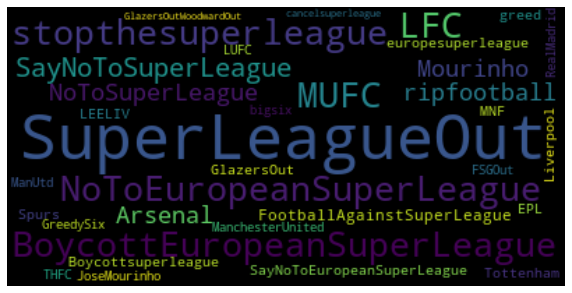

In [9]:
wordcloud(clean_hashtag)

The wordcloud is clear: the English Twitter mood was against the Super League. Other proeminent hashtags refers to the six British clubs and to 'greed', a word that was used quite often to refer to the teams and minds behind the Super League. See for example this [news](https://www.goal.com/en/news/chelsea-supporters-continue-call-for-high-profile/ykzxdv7f08ih164wm0eepjqpc) that discuss how Chelsea fans are still calling for high-profile resignation even after the club's withdrawal from the Super League.

### Waffle Plot

The WordCloud gives a good idea of the prevalence of hashtags against the SuperLeague among the opinionated hashtags. To investigate this proportion deeper, I classified manually all unique hashtags (9422) as `against` (1), `neutral` (2), or in `favor` (3) of the SuperLeague:

In [10]:
classified_hashtags = pd.read_csv('unique_hashtag_clean.csv').iloc[:, 1:]

In [11]:
classified_hashtags.label.value_counts()

2.0    8846
1.0     530
3.0      43
Name: label, dtype: int64

As we can see, the majority of the hashtags were not related or neutral to the SuperLeague. That's expected since the #SuperLeague was a trending topic on the 19th of April, and adding the #SuperLeague hashtag added visibility to a broad range of tweets.

Hence, I decided to leave the analysis of the `neutral` tweets aside and focus on the tweets against and in favor. First, let's see how many tweets had opinionated hashtags against and in favor of the SuperLeague.

In [12]:
# Get only hashtags in favor and against the superleague:
against_hashtag = classified_hashtags.hashtag[classified_hashtags.label==1]
favor_hashtag = classified_hashtags.hashtag[classified_hashtags.label==3]

In [13]:
# Filter against hashtags among all hashtags (to get the count of each one)
no_hashtags = [x for x in hashtags if x in list(against_hashtag)]
# Get top10 hashtags
top10_no_hashtags = list(pd.Series(no_hashtags).value_counts().head(10).index)

In [14]:
sl_tweets = (sl_tweets
             .assign(against=lambda y: [any(x in sublist for x in against_hashtag) for sublist in y.hashtags],
                     favor=lambda y: [any(x in sublist for x in favor_hashtag) for sublist in y.hashtags],
                     top10_against=lambda y: [any(x in sublist for x in top10_no_hashtags) for sublist in y.hashtags],
                     opinion=lambda x: np.where(x.against == True, 'Against',
                                               np.where(x.favor == True, 'Favor', np.nan)),
                     opinion_top10=lambda x: np.where(x.top10_against == True, 'Against',
                                               np.where(x.favor == True, 'Favor', np.nan)))
            )

In [15]:
all_count = sl_tweets.groupby('opinion')[['id']].count()
top10_count = sl_tweets.groupby('opinion_top10')[['id']].count()

pd.merge(all_count, top10_count,
        left_index=True, right_index=True).rename(columns={'id_x':'All', 'id_y':'Top 10'})

,All,Top 10
opinion,,
Against,7438,5563
Favor,97,99
nan,59697,61570


As we can see, the tweets with opinionated hashtags against the SuperLeague was overwhelmingly more present among the tweets talking about the SuperLeague than the tweets in favor of it. 

In percentual terms, **98.7%** of the opinionated tweets were against the SuperLeague. Even if we use only the 10 most popular hashtags against the SuperLeague, there would be **98.25%** of opinionated tweets against it. That's as close to a consensus as we can get nowadays.

These proportions are nicely visualized with a Waffle plot:

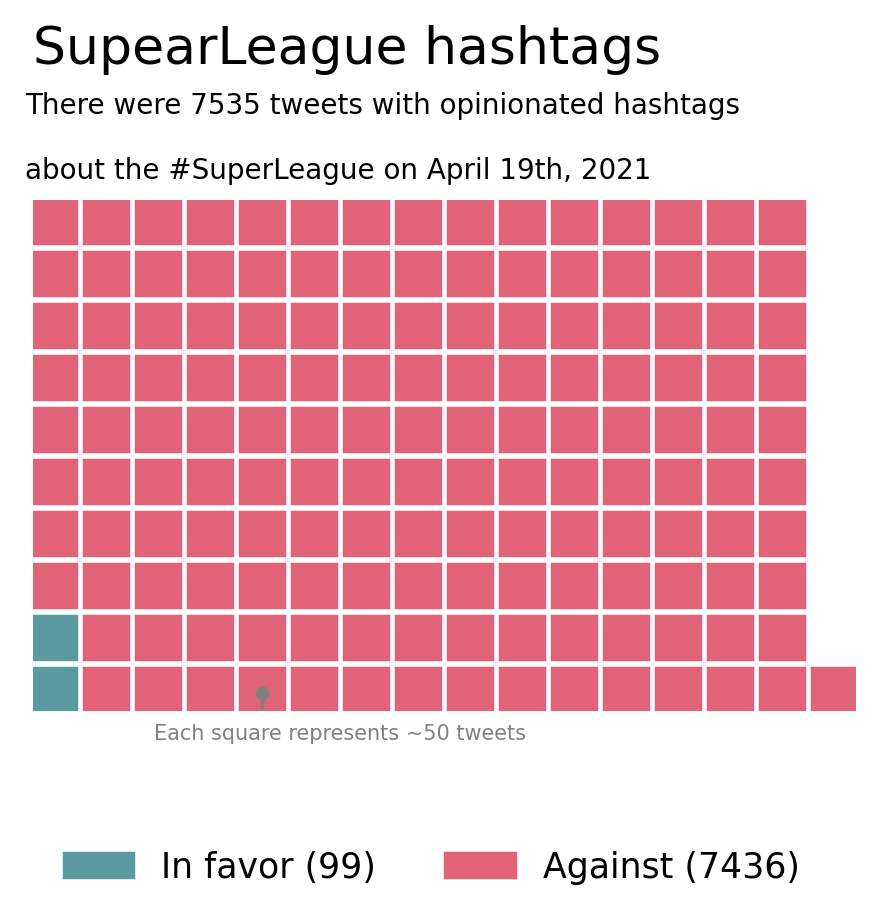

In [26]:
from pywaffle import Waffle

data = {'In favor (99)': 99/50, 'Against (7436)': 7436/50}

fig = plt.figure(
    FigureClass=Waffle, 
    rows=10, 
    values=data, 
    colors=("#5b9aa0", "#e06377"),
    title={'label': 'SupearLeague hashtags \n \n', 
           'loc': 'left',
          'fontdict': {
            'fontsize': 15
        }},
    legend={'loc': 'lower left', 
            'bbox_to_anchor': (0, -0.4), 
            'ncol': len(data), 
            'framealpha': 0,
            'fontsize': 10},
    dpi=250,
    figsize=(6,4)
    )

fig.text(
    x=0.23,
    y=0.27,
    s="Each square represents ~50 tweets",
    ha="center",
    va="center",
    fontsize=6,
    color='gray',
    alpha=1,
    bbox={
        'boxstyle': 'square', 
        'lw': 3, 
        'ec': 'gray', 
        'fc': (0.1, 0.1, 0.1, 0.1), 
        'alpha': 0
    }
)

plt.plot(0.448,0.035,color='grey', marker='.')
plt.plot([0.448, 0.448], [0, 0.035], '-', lw=1, color='grey')
plt.figtext(0.02, .825,
            '''There were 7535 tweets with opinionated hashtags 
            \nabout the #SuperLeague on April 19th, 2021''',
            fontsize=8,
            ha='left');


# fig.savefig('waffle.png')

### The most liked tweet

Finally, it is also interesting to note that the most liked tweet, with more than 98 thousand likes, was posted by Bastian Schweinsteiger, a famous football player from Bayern Munich that stated clearly his rejection to the proposal:

In [119]:
sl_tweets.sort_values('favorites', ascending=False).head(1).reset_index().full_text[0]

'If the #SuperLeague will be realized, it will destroy football with its national leagues as we know it and this is a very sad thought to me.'

Here is the link to the tweet: https://twitter.com/BSchweinsteiger/status/1384182809326080002?s=20

The next most liked tweets were either announcements from the UEFA that the clubs joining the Super League would be punished or the announcements of Sevilla and Borussia Dortmund that they would not take part on the league:

In [120]:
for i in range(1, 5):
    print(sl_tweets.sort_values('favorites', ascending=False).head(5).reset_index().full_text[i], '\n --')

UEFA’s Alexander Ceferin confirms: “The players that will play in the Super League will be banned from playing in the World Cup and Euros. Ceferin. They will not be allowed play for their national teams”. 🚫🇪🇺 #SuperLeague 
 --
Official: Borussia Dortmund have just announced that they’re *not* joining the #SuperLeague. 🟡⚫️ #BVB

“The clubs wants to implement the planned reform of the UEFA Champions League. The plans to found a Super League have been rejected”, BVB CEO Watzke said. 
 --
UEFA Executive Committee meeting scheduled for today in Montreux.

UEFA, FIFA, PL, Liga, Serie A on the same position: #SuperLeague has been disapproved. No UCL, no domestic leagues for the 12 clubs. 🚫

#SuperLeague clubs insist they want to play in the domestic leagues too. ⚠️ 
 --
Sevilla announces they’re not joining the #SuperLeague and they’ve no interest in this kind of project. “I’m so proud of our club, we say no to the Super League”, director of football @leonsfdo also added. 🚫🇪🇸 #Sevilla 
 --


### Conclusion

The analysis of the hashtags reinforced my perception from last week: football fans were overwhelmingly against the Super League. 

It would still be interesting to explore the content of the 67k tweets, and not only their hashtags. The problem is that the tweets are not classified beforehand, and known algorithms of sentiment analysis like `nltk` VADER fail to detect whether a tweet was in favor or against the Super League. An interesting idea would be to devise a classification system that would train on a subset of tweets in order to classify the whole set. I'll leave this exploration for a next post.

### Code

Link to github page